<a   href="https://colab.research.google.com/github/eduardojdiniz/Buzznauts/blob/master/scripts/demo_VideoDataFrame_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo VideoDataFrame Class 
This demo uses the Algonauts dataset.
    
TABLE OF CODE CONTENTS:
1. Minimal demo without image transforms
2. Minimal demo without sparse temporal sampling for single continuous frame clips, without image transforms
3. Demo with image transforms
4. Demo with image transforms and dataloader

For more details about the VideoDataFrame Class, see the [VideoDataset Repo](https://video-dataset-loading-pytorch.readthedocs.io/en/latest/VideoDataset.html)

### Setup 

In [61]:
# Download Buzznauts
!pip install duecredit --quiet
!git clone https://github.com/eduardojdiniz/Buzznauts --quiet

fatal: destination path 'Buzznauts' already exists and is not an empty directory.


In [62]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Load Buzznauts data functions
!pip install decord --quiet
from Buzznauts.Buzznauts.data.utils import plot_video
from Buzznauts.Buzznauts.data.videodataframe import VideoFrameDataset, ImglistToTensor

In [64]:
# Import pytorch
from torchvision import transforms
import torch

In [65]:
# Set videos and annotation file path
import os.path as op
stimuli = "/content/drive/MyDrive/Buzznauts/data/stimuli"
videos_root = op.join(stimuli, "frames")
annotation_file = op.join(videos_root, "annotations.txt")

### Demo 1 - Sampled Frames, without Image Transforms

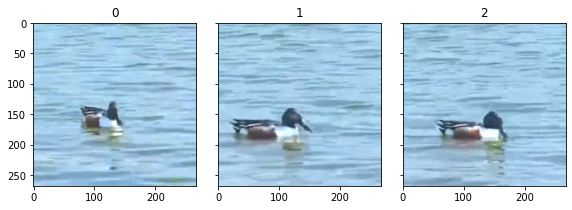

In [66]:
dataset = VideoFrameDataset(
    root_path=videos_root,
    annotationfile_path=annotation_file,
    num_segments=3,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=None,
    random_shift=True,
    test_mode=False)

sample = dataset[0]
frames = sample[0]  # list of PIL images
label = sample[1]   # integer label

plot_video(rows=1, cols=3, frame_list=frames, plot_width=15., plot_height=3.)

### Demo 2 - Single Continuous Frame Clip instead of Sampled Frames, without Image Transforms 

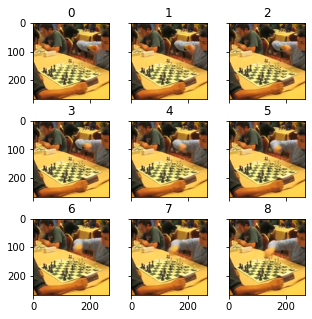

In [67]:
dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=9,
        imagefile_template='img_{:05d}.jpg',
        transform=None,
        random_shift=True,
        test_mode=False)

sample = dataset[5]
frames = sample[0]  # list of PIL images
label = sample[1]  # integer label

plot_video(rows=3, cols=3, frame_list=frames, plot_width=10., plot_height=5.)

### Demo 3 - Sampled Frames, with Image Transforms 

In [68]:
def denormalize(video_tensor):
    """Undoes mean/standard deviation normalization, zero to one scaling, and channel rearrangement for a batch of images.
    
    Parameters
    ----------
    video_tensor : tensor.FloatTensor 
        A (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        
    Returns
    ----------
    video_array : numpy.ndarray[float]
        A (FRAMES x CHANNELS x HEIGHT x WIDTH) numpy array of floats
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()

In [69]:
# As of torchvision 0.8.0, torchvision transforms support batches of images
# of size (BATCH x CHANNELS x HEIGHT x WIDTH) and apply deterministic or random
# transformations on the batch identically on all images of the batch. Any torchvision
# transform for image augmentation can thus also be used  for video augmentation.
preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    transforms.Resize(299),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(299),  # image batch, center crop to square 299x299
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = VideoFrameDataset(
    root_path=videos_root,
    annotationfile_path=annotation_file,
    num_segments=5,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=preprocess,
    random_shift=True,
    test_mode=False
)

sample = dataset[2]
frame_tensor = sample[0]  # tensor of shape (NUM_SEGMENTS*FRAMES_PER_SEGMENT) x CHANNELS x HEIGHT x WIDTH
label = sample[1]  # integer label

print('Video Tensor Size:', frame_tensor.size())

Video Tensor Size: torch.Size([5, 3, 299, 299])


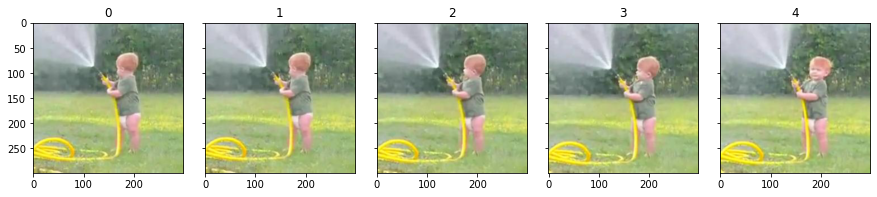

In [70]:
frame_array = denormalize(frame_tensor)
plot_video(rows=1, cols=5, frame_list=frame_array, plot_width=15., plot_height=3.)

### Demo 4 - Sampled Frames Dataloader, with Image Transforms 

In [73]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=2,
        shuffle=True,
        num_workers=2,
        pin_memory=True)

for epoch in range(10):
    for video_batch, labels in dataloader:
        """
        Insert Training Code Here
        """
        print(labels)
        print("\nVideo Batch Tensor Size:", video_batch.size())
        break
    break

('0555_flickr-4-4-1-5-9-1-8-3-4944159183_18', '0623_flickr-5-2-5-4-2-9-7-7-8052542977_33')

Video Batch Tensor Size: torch.Size([2, 5, 3, 299, 299])


method-1:

In [78]:
from torch.utils.data.sampler import SubsetRandomSampler
train_size = int(0.8 * len(dataset))
train_set  = torch.utils.data.DataLoader(dataset, batch_size=2, sampler=SubsetRandomSampler(indices[:train_size]))
test_set  = torch.utils.data.DataLoader(dataset, batch_size=2, sampler=SubsetRandomSampler(indices[train_size:]))

method-2:

In [75]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])